<a href="https://colab.research.google.com/github/LapTQ/handwritten_text_recognition/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Open in Colab](https://colab.research.google.com/github/LapTQ/handwritten_text_recognition/blob/main/demo.ipynb)

https://excalidraw.com/#room=da5fbbdb8ae8e17a0e8d,rLBfY6UNZueKq4VnvKFRZA
https://docs.opencv.org/4.x/dc/dc3/tutorial_py_matcher.html

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Image alignment

In [7]:
def process_for_contour(img, **kwargs):
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # XỬ LÝ ẢNH: làm mờ ảnh để tập trung vào phần khung giấy
    if 'median_ksize' not in kwargs:
        kwargs['median_ksize'] = 15
    img_blur = cv2.medianBlur(img_gray, kwargs['median_ksize'])

    # ### START DEMO
    # plt.figure(figsize=(10, 10))
    # plt.imshow(img_blur, cmap='gray')
    # plt.show()
    # ### END DEMO

    if 'mode' not in kwargs:
        kwargs['mode'] = 'thresh'
    assert kwargs['mode'] == 'thresh' or kwargs['mode'] == 'edge'

    if kwargs['mode'] == 'thresh':
        if 'use_page_median' not in kwargs:
            kwargs['use_page_median'] = True

        if kwargs['use_page_median']:
            H, W = img_blur.shape[:2]
            lower, upper = 0.4, 0.6
            page_median = np.median(img_blur[int(lower * H):int(upper * H), int(lower * W):int(upper * W)])
            thresh1, thresh2 = max(1, page_median - 10), min(page_median + 10, 254)
            ret, thresh1 = cv2.threshold(img_blur, thresh1, 255, cv2.THRESH_BINARY)
            ret, thresh2 = cv2.threshold(255 - img_blur, 255 - thresh2, 255, cv2.THRESH_BINARY)
            out_img = np.logical_and(thresh1, thresh2).astype(np.uint8)
        else:
            ret, out_img = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    else:
        if 'threshold1' not in kwargs:
            kwargs['threshold1'] = 100
        if 'threshold2' not in kwargs:
            kwargs['threshold2'] = 200
        out_img = cv2.Canny(img_blur, kwargs['threshold1'], kwargs['threshold2'])

    # ### START DEMO
    # plt.figure(figsize=(10, 10))
    # plt.imshow(out_img, cmap='gray')
    # plt.show()
    # ### END DEMO

    return out_img

def auto_detect_corners(processed_img):
    """
    Get 4 corner-coordinates of scanned document in a preprocessed grayscale image.
    :param processed_img: gray-scale np-array image
    :return: np-array shape (4, 1, 2) coordinates of top-left, bottom-left, bottom-right, top-right corners
    """

    contours, hierarchy = cv2.findContours(
        image=processed_img,
        mode=cv2.RETR_CCOMP,
        method=cv2.CHAIN_APPROX_NONE
    )

    # xấp xỉ đa giác
    epsilon = [0.1 * cv2.arcLength(cnt, True) for cnt in contours]
    quad_approx = [cv2.approxPolyDP(cnt, ep, True) for cnt, ep in zip(contours, epsilon)]

    # làm sao dể biết contour nào là của giấy?
    # tạm thời dựa vào diện tích
    H, W = processed_img.shape[:2]
    for corners in quad_approx:
        if cv2.contourArea(corners) >= H * W / 10 and len(corners) == 4:
            return corners

def corner_warping(img, corners):
    """
    Perspective warping image using corners of the page.
    :param img: np-array image
    :param corners: (x, y) coordinates of top-left, bottom-left, bottom-right, top-right corners
    :return: warped image
    """
    assert corners.shape == (4, 1, 2), f"shape should be (4, 1, 2) for the convenience of OpenCV. Got {corners.shape}"

    # tìm box (theo trục): xywh (xy top-left)
    rect = cv2.boundingRect(corners)
    x1, y1, w, h = rect

    # crop ảnh và tính lại tọa độ các góc
    img = img[y1:y1 + h, x1:x1 + w]
    corners[:, :, 0] = corners[:, :, 0] - x1
    corners[:, :, 1] = corners[:, :, 1] - y1
    # tọa độ warp bằng 4 góc của ảnh đã crop
    target_coord = np.array([[0, 0], [0, h], [w, h], [w, 0]]).reshape(corners.shape)

    homography, mask = cv2.findHomography(corners, target_coord, cv2.RANSAC)    # hoặc dùng hàm cv2.getPerspectiveTransform
    warped_img = cv2.warpPerspective(img, homography, (w, h))

    return warped_img

def trivial_corner(img_shape):
    """
    Return a trivial corners set when auto detection is not feasible.
    :param img_shape: tuple, shape of image
    :return: numpy array of shape (4, 1, 2)
    """
    H, W = img_shape[:2]
    return np.array([[int(W * 0.25), int(H * 0.25)],
                     [int(W * 0.25), int(H * 0.75)],
                     [int(W * 0.75), int(H * 0.75)],
                     [int(W * 0.75), int(H * 0.25)]]).reshape(4, 1, 2)

In [8]:
def template_alignment(img, template):
    """
    Align image using template
    :param img: np-array in OpenCV BGR format
    :param template: np-array in OpenCV BGR format
    :return: np-array in OpenCV BGR format
    """

    # chuyển về ảnh grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    template_gray = cv2.cvtColor(template, cv2.COLOR_BGR2GRAY)

    # sử dụng SIFT descriptor
    detector = cv2.SIFT_create()
    kp_img, des_img = detector.detectAndCompute(img_gray, None)
    kp_template, des_template = detector.detectAndCompute(template_gray, None)

    # tìm các cặp bằng Brute force và KNN
    matcher = cv2.BFMatcher()
    matches = matcher.knnMatch(des_img, des_template, k=2)

    # lấy ra các cặp tốt (theo bài báo của SIFT)
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    # trựa quan hóa các cặp (không có ích gì cho hàm)
    matching_img = cv2.drawMatches(img_gray, kp_img, template_gray, kp_template, good, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

    # tạo biến lưu tọa độ các cặp
    img_points = np.zeros((len(good), 2), dtype=np.float32)
    template_points = np.zeros((len(good), 2), dtype=np.float32)

    for i, match in enumerate(good):
        img_points[i, :] = kp_img[match.queryIdx].pt
        template_points[i, :] = kp_template[match.trainIdx].pt

    homography, mask = cv2.findHomography(img_points, template_points, cv2.RANSAC)

    H, W, D = template.shape
    img_reg = cv2.warpPerspective(img, homography, (W, H))

    return img_reg

In [9]:
def arrange_corners(corners):
    """
    Arrange corner in the order: top-left, bottom-left, bottom-right, top-right
    :param corners: numpy array of shape (4, 1, 2)
    :return: numpy array of shape (4, 1, 2)
    """
    assert corners.shape == (4, 1, 2), f"corners must be of shape (4, 1, 2). Got {corners.shape}"
    shape = corners.shape
    corners = np.squeeze(corners).tolist()
    corners = sorted(corners, key=lambda x: x[0])
    corners = sorted(corners[:2], key=lambda x: x[1]) + sorted(corners[2:], key=lambda x: x[1], reverse=True)
    return np.array(corners).reshape(shape)

In [10]:
img_path = 'img2.png'
img = cv2.imread(img_path)

use_corner = True

if input('Do you have template? [y/n] ').strip()[0].lower() == 'y':
    # TODO: cho người dùng chọn template ở đây
    template_path = 'template.jpg'
    template = cv2.imread(template_path)

    img_reg = template_alignment(img, template)

    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(img_reg, cv2.COLOR_BGR2RGB))
    # plt.show()
    cv2.namedWindow('Preview')
    cv2.imshow('Preview', img_reg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    use_corner = input('Alignment using template. Is this okay? [y/n] ').strip()[0].lower() != 'y'


if use_corner:
    processed_img = process_for_contour(img, mode='thresh', use_page_median=True)
    corners = auto_detect_corners(processed_img)
    if corners is None:
        processed_img = process_for_contour(img, mode='thresh', use_page_median=False)
        corners = auto_detect_corners(processed_img)
    if corners is None:
        processed_img = process_for_contour(img, mode='edge')
        corners = auto_detect_corners(processed_img)

    if corners is None:
        corners = trivial_corner(img.shape)

    demo_img = img.copy()
    cv2.drawContours(
        image=demo_img,
        contours=[corners],
        contourIdx=-1,
        color=(0, 255, 0),
        thickness=2,
        lineType=cv2.LINE_AA
    )
    for center in corners:
        center = center[0]
        cv2.circle(
            demo_img,
            center,
            radius=2,
            color=(0, 0, 255),
            thickness=2
        )

    # plt.figure(figsize=(10, 10))
    # plt.imshow(cv2.cvtColor(demo_img, cv2.COLOR_BGR2RGB))
    # plt.show()
    cv2.namedWindow('Auto detect corners preview')
    cv2.imshow('Auto detect corners preview', demo_img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

    if input('Auto detect corners. Is this okay? [y/n] ').strip()[0].lower() != 'y':

        global img_copy
        global buffer

        def on_mouse(event, x, y, flags, param):
            global buffer
            global img_copy

            if event == cv2.EVENT_LBUTTONDOWN:
                cv2.circle(img_copy, (x, y), radius=4, color=(0, 0, 255), thickness=8)
                if len(buffer) > 0:
                    cv2.line(img_copy, (x, y), buffer[-1], color=(0, 255, 0), thickness=2)
                if len(buffer) == 3:
                    cv2.line(img_copy, (x, y), buffer[0], color=(0, 255, 0), thickness=2)
                buffer.append([x, y])
                cv2.imshow('Please specify corners', img_copy)


        cv2.namedWindow('Please specify corners')
        img_copy = img.copy()
        cv2.imshow('Please specify corners', img_copy)

        corner_selected = False

        while not corner_selected:
            img_copy = img.copy()
            buffer = []
            cv2.imshow('Please specify corners', img_copy)
            cv2.setMouseCallback('Please specify corners', on_mouse)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

            corner_selected = input('Are you sure with your choice? [y/n] ').strip()[0].lower() == 'y'

        # TODO viết hàm sắp xếp các góc
        corners = np.array(buffer).reshape(4, 1, 2)
        corners = arrange_corners(corners)

    img_reg = corner_warping(img, corners)

# print('Final alignment is:')
# plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(img_reg, cv2.COLOR_BGR2RGB))
# plt.show()
if use_corner:
    cv2.namedWindow('Final alignment')
    cv2.imshow('Final alignment', img_reg)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

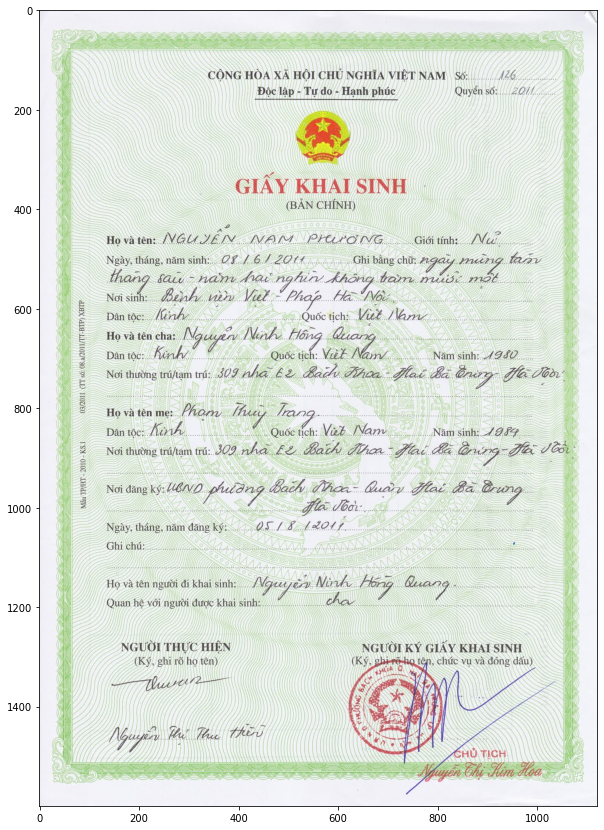

In [12]:
img_path = 'img9.jpg'

img = cv2.imread(img_path)

plt.figure(figsize=(10, 20))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [20]:
# python3 test.py --trained_model weights/craft_mlt_25k.pth--cuda False --refine True --refiner_model weights/craft_refiner_CTW1500.pth

/media/tran/003D94E1B568C6D11/Workingspace/handwritten_text_recognition


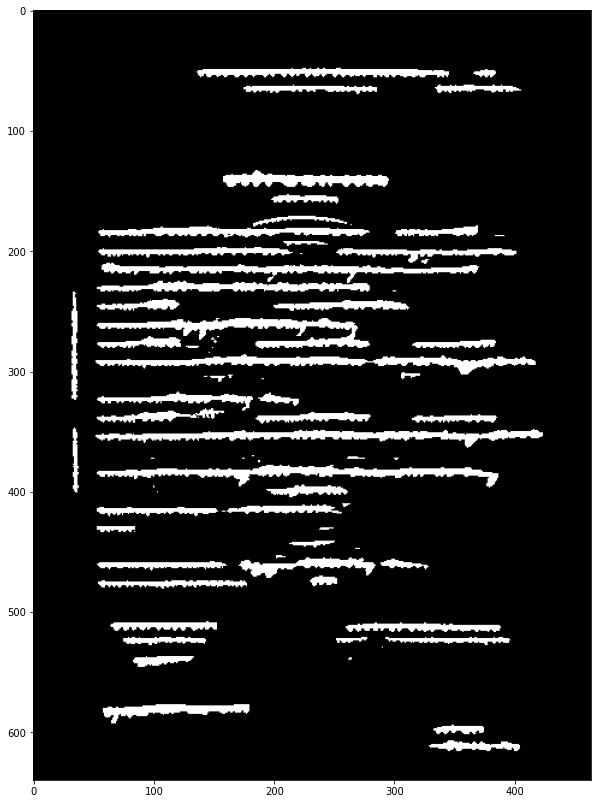

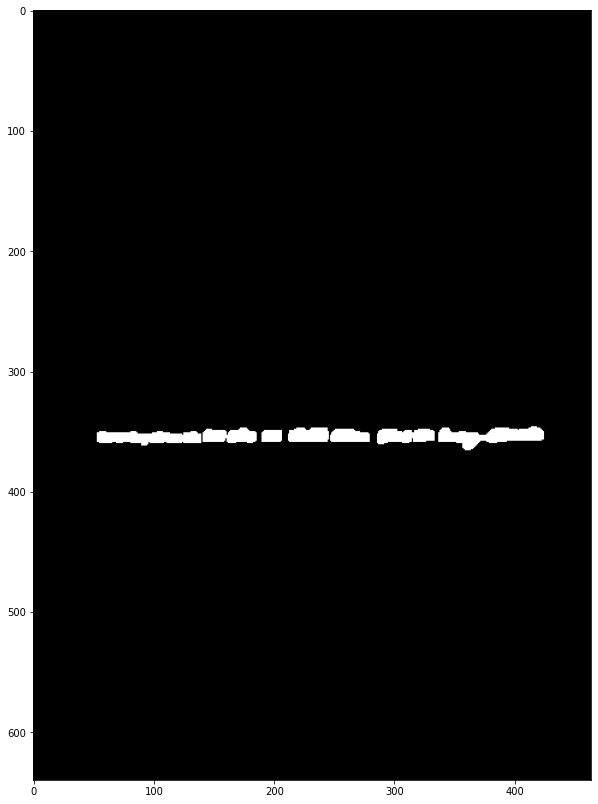

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[ 52.956543 347.4919  ]
 [423.9833   345.95877 ]
 [424.06094  364.7477  ]
 [ 53.03418  366.28085 ]]


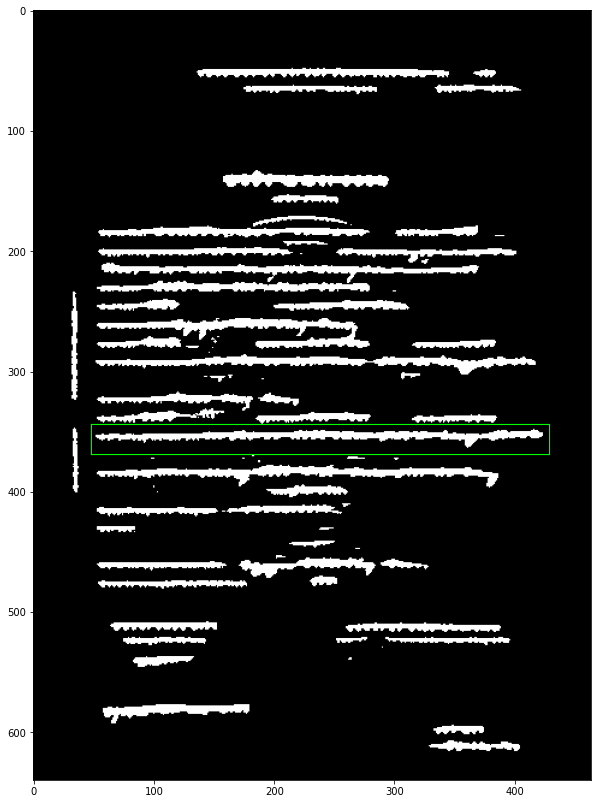

In [61]:
import pickle
import matplotlib.pyplot as plt
import cv2
import numpy as np
import math

with open('CRAFT/textmap.pkl', 'rb') as f:
    textmap = pickle.load(f)
f.close()

with open('CRAFT/linkmap.pkl', 'rb') as f:
    linkmap = pickle.load(f)
f.close()

img_h, img_w = textmap.shape

text_threshold = 0.7
link_threshold = 0.4
low_text = 0.4

def show(img, subplot=None):
    if subplot is None:
        plt.figure(figsize=(10, 20))
    else:
        if subplot == 1:
            plt.figure(figsize=(20, 20))
        plt.subplot(1, 2, subplot)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(img)
    if subplot != 1:
        plt.show()

# show(textmap, 1)
# show(linkmap, 2)

# # THỬ CÁCH KHÁC: công trước khi threshold
# demo = textmap + linkmap
# demo = np.clip(demo, 0, 1) # (demo / np.max(demo))# * 255).astype(np.uint8)
# # show(demo, 1)
# ret, demo = cv2.threshold(demo, 0.8, 1, 0)
# # show(demo, 2)
# # HẾT

ret, text_score = cv2.threshold(textmap, low_text, 1, 0)
ret, link_score = cv2.threshold(linkmap, link_threshold, 1, 0)

# show(text_score, 1)
# show(link_score, 2)

text_score_comb = np.clip(text_score + link_score, 0, 1)

# nLabels: số vùng, bao gồm cả vùng 0 (background)
# labels: kích thước bằng ảnh, chứa index của vùng cho mỗi pixel
# stats: với mỗi label, đưa ra thông tin về vùng đó
# centroid: với mỗi vùng, đưa ra tâm của vùng
nLabels, labels, stats, centroids = cv2.connectedComponentsWithStats(text_score_comb.astype(np.uint8), connectivity=4)

det = []
mapper = []

demo = cv2.cvtColor(text_score_comb, cv2.COLOR_GRAY2BGR)
# demo[:3, :3] = 1
show(demo)
for k in range(1, nLabels):
    # if stats[k, cv2.CC_STAT_AREA] < 10:
    #     demo[labels==k] = 0
    # if np.max(textmap[labels==k]) < text_threshold:
    #     demo[labels==k] = 0

    # bỏ qua cc k nếu diện tích của nó < 10
    size = stats[k, cv2.CC_STAT_AREA]
    if size < 10: continue

    # bỏ qua cc k nếu max(region score) tương ứng với nó < 0.7
    if np.max(textmap[labels==k]) < text_threshold: continue

    # tạo segmentation map CHỈ chứa các region thuộc cc thứ k
    segmap = np.zeros(textmap.shape, dtype=np.uint8)
    segmap[labels==k] = 255
    segmap[np.logical_and(link_score==1, text_score==0)] = 0   # remove link area

    # tính tọa độ của 4 góc  (chừa ra một ít)
    x, y = stats[k, cv2.CC_STAT_LEFT], stats[k, cv2.CC_STAT_TOP]
    w, h = stats[k, cv2.CC_STAT_WIDTH], stats[k, cv2.CC_STAT_HEIGHT]
    niter = int(math.sqrt(size * min(w, h) / (w * h)) * 2)
    sx, ex, sy, ey = x - niter, x + w + niter + 1, y - niter, y + h + niter + 1
    # boundary check
    if sx < 0 : sx = 0
    if sy < 0 : sy = 0
    if ex >= img_w: ex = img_w
    if ey >= img_h: ey = img_h

    # dilate các segment của từng chữ, TỐI ĐA trong vùng của 4 góc vừa tính
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(1 + niter, 1 + niter))
    segmap[sy:ey, sx:ex] = cv2.dilate(segmap[sy:ey, sx:ex], kernel)

    # tạo bounding box (tọa độ 4 góc)
    np_contours = np.roll(np.array(np.where(segmap!=0)),1,axis=0).transpose().reshape(-1,2)
    rectangle = cv2.minAreaRect(np_contours)
    box = cv2.boxPoints(rectangle)

    # align diamond-shape
    w, h = np.linalg.norm(box[0] - box[1]), np.linalg.norm(box[1] - box[2])
    box_ratio = max(w, h) / (min(w, h) + 1e-5)
    if abs(1 - box_ratio) <= 0.1:
        l, r = min(np_contours[:,0]), max(np_contours[:,0])
        t, b = min(np_contours[:,1]), max(np_contours[:,1])
        box = np.array([[l, t], [r, t], [r, b], [l, b]], dtype=np.float32)

    # make clock-wise order
    # sau 3 lệnh này thì box có format (lt, lb, rg, rt)
    startidx = box.sum(axis=1).argmin()
    box = np.roll(box, 4-startidx, 0)
    box = np.array(box)

    det.append(box)
    mapper.append(k)

    if k == 47:
        show(segmap)
        print(box)
        cv2.rectangle(demo, (sx, sy), (ex, ey), color=(0, 255, 0))
        show(demo)



dùng CRAFT để tìm box
=> bước phụ: tính tọa độ tâm của giấy dựa trên các box => tìm khổ giấy, làm thẳng giấy
dùng kết quả để chỉnh độ nghiêng của giấy => các chữ trong cùng 1 hàng sẽ cùng nằm theo chiều ngang
dilate theo chiều ngang, erode theo chiều dọc => các chữ gần nhau sẽ bị dính vào nhau => tính được box chung hoặc cái ĐOẠN ngang chính.
tìm các box dính với cái box chung (mà có hướng ngang là hướng chính) đấy
tìm median hoặc mean của cạnh trên, cạnh dưới, và min (max) của cạnh trái (phải) => box mới, lọc bỏ những cái đã chọn đi

với các box chung mà có hướng dọc là hướng chính, thì dilate, dilae theo hướng ngược lại....

# Preprocess for text detection

Nếu dùng mạng neuron để detect thì có cần tiền xử lý không, hay là vẫn detect được rồi xử lý sau?

https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/
https://medium.com/technovators/survey-on-image-preprocessing-techniques-to-improve-ocr-accuracy-616ddb931b76
https://medium.com/analytics-vidhya/enhance-a-document-scan-using-python-and-opencv-9934a0c2da3d
https://repository.vnu.edu.vn/bitstream/VNU_123/6297/1/00050001352.pdf
https://arxiv.org/abs/1901.06081

blur correction

remove noise

Deskew

Lines Straightening



In [ ]:
img = img_reg

img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)

# hist = cv2.calcHist(img_hls, [1], None, [256], [0, 256])
# plt.plot(hist)
# plt.show()
#
# x = np.linspace(0, 255, 256)
# def f(x, k, m):
#     return int(255 / (1 + np.exp(-k * (x - m))))
#
# fv = np.vectorize(lambda x: f(x, 0.1, 75))
# y = fv(x)
# plt.plot(x, y)
# plt.show()
#
# img_hls[:, :, 1] = fv(img_hls[:, :, 1])

img_hls[:, :, 1] = cv2.adaptiveThreshold(
    img_hls[:, :, 1],
    55,  # maximum value assigned to pixel values exceeding the threshold
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C,  # gaussian weighted sum of neighborhood
    cv2.THRESH_BINARY,  # thresholding type
    15,  # block size (5x5 window)
    3
)

img = cv2.cvtColor(img_hls, cv2.COLOR_HLS2BGR)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


plt.figure(figsize=(20, 20))
plt.imshow(img_gray, cmap='gray')
plt.show()

In [ ]:

# img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# img_blur = cv2.medianBlur(img_gray, 15)
#
# H, W = img_blur.shape[:2]
# lower, upper = 0.4, 0.6
# page_median = np.median(img_blur[int(lower * H):int(upper * H), int(lower * W):int(upper * W)])
# print(page_median)
#
# hist = cv2.calcHist([img_blur], [0], None, [256], [0, 256])
# hist = hist / (H * W)
# plt.plot(hist)
# plt.show()
#
# # chọn dựa trên khoảng cách và tấn suất (liệu có cần tần suất không?)
# scores = np.zeros_like(hist)
# for i in range(256):
#     scores[i] = 0.05 * 1/(np.abs(page_median - i) + 1) + hist[i]
# plt.plot(scores)
# plt.show()
#
# page_color = np.argmax(scores)
# threshold1, threshold2 = max(0, page_color - 10), min(page_color + 20, 220)
#
# ret, thresh1 = cv2.threshold(img_blur, threshold1, 255, cv2.THRESH_BINARY)
# ret, thresh2 = cv2.threshold(255 - img_blur, 255 - threshold2, 255, cv2.THRESH_BINARY)
# ret, thresh = cv2.threshold(img_blur, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# plt.figure(figsize=(10, 10))
# plt.imshow(thresh, cmap='gray')
# plt.show()



# peaks = []
# wsize = 11
# hist_pad = np.concatenate([np.zeros(((wsize - 1)//2, 1), dtype=np.float32),
#                            hist,
#                            np.zeros(((wsize - 1)//2, 1), dtype=np.float32)],
#                           axis=0)
# for i in range((wsize - 1)//2, len(hist) - (wsize - 1)//2):


# gaussian_smooth = np.array([.006, .061, .242, .383, .242, .061, .006])
# hist = np.concatenate([np.zeros((3,1), dtype=np.float32), hist, np.zeros((3,1), dtype=np.float32)], axis=0)
# for i in range(3, len(hist) - 3):
#     hist[i, 0] = np.sum(hist[i - 3: i + 4, 0] * gaussian_smooth)
# hist = hist[3:-3]
#
# plt.plot(hist)
# plt.show()
#
# demo_img = img_blur

In [ ]:
import math

img_path = 'img2.png'
img = cv2.imread(img_path)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
img_blur = cv2.medianBlur(img_gray, 15)
img_edges = cv2.Canny(img_blur, 100, 200)

lines = cv2.HoughLines(img_edges, 1, np.pi/180, 150, None, 0, 0)
for i in range(len(lines)):
    rho = lines[i][0][0]
    theta = lines[i][0][1]
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(img, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


plt.figure(figsize=(10, 10))
plt.imshow(img, cmap='gray')


In [ ]:
!git clone https://github.com/LapTQ/handwritten_text_recognition.git
!pip install jiwer
%cd handwritten_text_recognition

In [ ]:
!python train.py --invert_color True